In [55]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import easydict

In [56]:
def load_data(is_train=True):
    if is_train:
        sensor_path = './dataset/SWaT/SWaT_Dataset_Normal_v0.csv'
        df = pd.read_csv(sensor_path, index_col=0)
    else:
        sensor_path = './dataset/SWaT/SWaT_Dataset_Attack_v0.csv'
        df = pd.read_csv(sensor_path, index_col=0)

    for var_index in [item for item in df.columns if item != 'Normal/Attack']:
        df[var_index] = pd.to_numeric(df[var_index], errors='coerce')
    df.reset_index(drop=True, inplace=True)
    df.fillna(method='ffill', inplace=True)

    print(df.head())
    x = df.values[:,:-1].astype(np.float32)
    y = (df['Normal/Attack']=='Attack').to_numpy().astype(int)

    return x, y

In [57]:
train_x, train_y = load_data(True)
test_x, test_y = load_data(False)

     FIT101    LIT101  MV101  P101  P102    AIT201   AIT202   AIT203  \
0  2.470294  261.5804      2     2     1  244.3284  8.19008  306.101   
1  2.457163  261.1879      2     2     1  244.3284  8.19008  306.101   
2  2.439548  260.9131      2     2     1  244.3284  8.19008  306.101   
3  2.428338  260.2850      2     2     1  244.3284  8.19008  306.101   
4  2.424815  259.8925      2     2     1  244.4245  8.19008  306.101   

     FIT201  MV201  ...  P501  P502    PIT501  PIT502    PIT503    FIT601  \
0  2.471278      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
1  2.468587      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
2  2.467305      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
3  2.466536      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
4  2.466536      2  ...     1     1  10.02948     0.0  4.277749  0.000256   

   P601  P602  P603  Normal/Attack  
0     1     1     1         Normal  
1     1     1     1         No

In [58]:
x_min = np.min(train_x, 0, keepdims=True)
x_max = np.max(train_x, 0, keepdims=True)

In [59]:
args = easydict.EasyDict({
    "batch_size": 128,
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    "input_size": train_x.shape[1],
    "latent_size": 10,
    "output_size": train_x.shape[1],
    "window_size" : 100,
    "num_layers": 2,
    "learning_rate" : 0.001,
    "max_iter" : 100000,
    'early_stop' : True,
})

In [60]:
class SWaTDataset(Dataset):
    def __init__(self, x, y, x_min, x_max, window_size=1):
        super().__init__()
        t = (x_min != x_max).astype(np.float32)
        self.x = (x - x_min) / (x_max-x_min + 1e-5) * t
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return self.x.shape[0] - self.window_size + 1

    def __getitem__(self, idx):
        return self.x[idx:idx+self.window_size], self.y[idx:idx+self.window_size]

In [61]:
train_dataset = SWaTDataset(train_x, train_y, x_min, x_max, window_size=args.window_size)
test_dataset = SWaTDataset(test_x, test_y, x_min, x_max, window_size=args.window_size)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=args.batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=args.batch_size,
                shuffle=False)

In [62]:
from LSTM_ENC_DEC_AD.model import LSTMAutoEncoder

model = LSTMAutoEncoder(
    input_dim=args.input_size,
    latent_dim=args.latent_size,
    window_size=args.window_size,
    num_layers=args.num_layers
)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(51, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(51, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=51, bias=True)
  )
)

In [63]:
def loss_function(x, pred_x):
    loss = F.mse_loss(x, pred_x)
    return loss

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

In [65]:
## Training
best_loss = None
epochs = tqdm(range(args.max_iter//len(train_loader)+1), leave=True)
for epoch in epochs:
    model.train()
    optimizer.zero_grad()
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training", leave=True)

    train_loss = 0.0
    for i, batch_data in train_iterator:
        batch_data = batch_data[0].to(args.device)
        predict_values = model(batch_data)

        optimizer.zero_grad()
        loss = loss_function(batch_data, predict_values)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iterator.set_postfix({
            "train_loss": float(loss),
        })

    train_loss = train_loss / len(train_loader)
    epochs.set_postfix({
         "Train Loss": train_loss,
    })

    model.eval()
    eval_loss = 0
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing", leave=True)
    with torch.no_grad():
        for i, batch_data in test_iterator:

            batch_data = batch_data[0].to(args.device)
            predict_values = model(batch_data)
            loss = loss_function(batch_data, predict_values)

            eval_loss += loss.mean().item()

            test_iterator.set_postfix({
                "eval_loss": float(loss),
            })

    eval_loss = eval_loss / len(test_loader)
    epochs.set_postfix({
         "Evaluation Score": float(eval_loss),
    })
    if best_loss is None or eval_loss < best_loss:
        best_loss = eval_loss
    else:
        if args.early_stop:
            print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
            break


  0%|          | 0/26 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

early stop condition   best_loss[0.10057650050150024]  eval_loss[0.10729416287605151]


In [66]:
def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    loss_list = []

    model.eval()
    with torch.no_grad():
        for i, batch_data in test_iterator:
            batch_data = batch_data[0].to(args.device)
            predict_values = model(batch_data)

            loss = F.l1_loss(batch_data, predict_values, reduce=False)
            loss = loss.mean(dim=1).cpu().numpy()
            loss_list.append(loss)

    loss_list = np.concatenate(loss_list, axis=0)
    return loss_list

In [67]:
train_loss_list = get_loss_list(args, model, train_loader)
test_loss_list = get_loss_list(args, model, test_loader)

testing:   0%|          | 0/3881 [00:00<?, ?it/s]

/home/nas3_userJ/dmkim/anaconda3/envs/TSAD/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


testing:   0%|          | 0/3515 [00:00<?, ?it/s]

In [68]:
train_loss_list.shape, test_loss_list.shape

((496701, 51), (449820, 51))

In [69]:
mean = np.mean(train_loss_list, axis=0)
std = np.cov(train_loss_list.T)

## Anomaly Score
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1]
        self.mean = mean
        self.std = std

    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

anomaly_calculator = Anomaly_Calculator(mean, std)
anomaly_scores = []
for temp_loss in tqdm(test_loss_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

print("mean[{}], median[{}], min[{}], max[{}]".format(np.mean(anomaly_scores), np.median(anomaly_scores), np.min(anomaly_scores), np.max(anomaly_scores)))

  0%|          | 0/449820 [00:00<?, ?it/s]

mean[0.013895690585142974], median[0.01266182698045489], min[8.433540878284173e-06], max[0.07043973301253968]


In [70]:
x = list(range(len(anomaly_scores)))
y = anomaly_scores

window_y = []
for i in x:
    window_y.append(min(test_y[i:i+args.window_size])==1)

intervals = []
start = None
for i, label in enumerate(window_y):
    if label:
        if start is None:
            start = i
    else:
        if start is not None:
            intervals.append((start, i-1))
        start = None
if start is not None:
    intervals.append((start, len(window_y)-1))

In [71]:
print(intervals)

[(1754, 2594), (3068, 3411), (4920, 5203), (6459, 6749), (7255, 7351), (7705, 8034), (11410, 12274), (15380, 16001), (73800, 74421), (90685, 90818), (92140, 92471), (93445, 93621), (103092, 103709), (115843, 116002), (116143, 116438), (117000, 117621), (132918, 133281), (142954, 143551), (172305, 172489), (172910, 173422), (198296, 199641), (227828, 263628), (279120, 279141), (280060, 281131), (302653, 302920), (347679, 348180), (361191, 361535), (371479, 371480), (371855, 372236), (389680, 390120), (436541, 436910), (437417, 437598), (438147, 438448), (438621, 438818), (443501, 445091)]


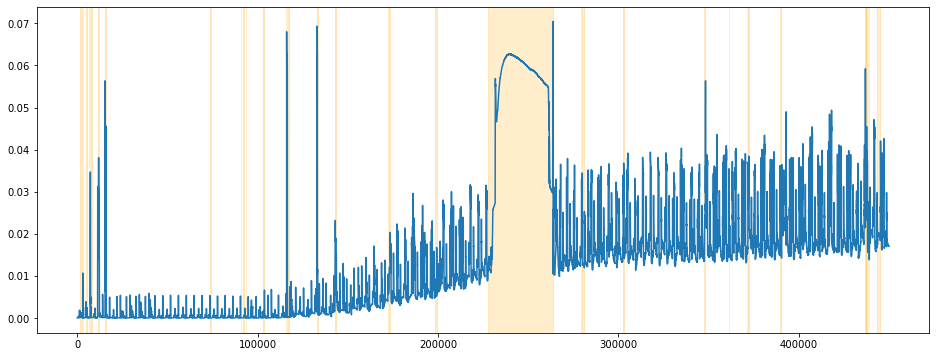

In [72]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot()

ax.plot(x, y)
plt.rcParams['axes.facecolor']='white'
for s, e in intervals:
    ax.axvspan(s, e, alpha=0.2, color='orange')

### Finding Threshold

In [73]:
len(anomaly_scores), anomaly_scores[0]

(449820, 4.615103869823858e-05)

In [74]:
anomaly_min, anomaly_max = np.min(anomaly_scores), np.max(anomaly_scores)
anomaly_min, anomaly_max

(8.433540878284173e-06, 0.07043973301253968)

In [75]:
test_y.shape

(449919,)

In [76]:
thresholds = np.linspace(anomaly_min, anomaly_max, 100)

In [77]:
print(thresholds)

[8.43354088e-06 7.19860808e-04 1.43128808e-03 2.14271534e-03
 2.85414261e-03 3.56556988e-03 4.27699715e-03 4.98842441e-03
 5.69985168e-03 6.41127895e-03 7.12270621e-03 7.83413348e-03
 8.54556075e-03 9.25698802e-03 9.96841528e-03 1.06798426e-02
 1.13912698e-02 1.21026971e-02 1.28141244e-02 1.35255516e-02
 1.42369789e-02 1.49484062e-02 1.56598334e-02 1.63712607e-02
 1.70826880e-02 1.77941152e-02 1.85055425e-02 1.92169698e-02
 1.99283970e-02 2.06398243e-02 2.13512516e-02 2.20626788e-02
 2.27741061e-02 2.34855334e-02 2.41969606e-02 2.49083879e-02
 2.56198152e-02 2.63312424e-02 2.70426697e-02 2.77540970e-02
 2.84655242e-02 2.91769515e-02 2.98883788e-02 3.05998060e-02
 3.13112333e-02 3.20226606e-02 3.27340878e-02 3.34455151e-02
 3.41569424e-02 3.48683696e-02 3.55797969e-02 3.62912242e-02
 3.70026514e-02 3.77140787e-02 3.84255060e-02 3.91369332e-02
 3.98483605e-02 4.05597878e-02 4.12712150e-02 4.19826423e-02
 4.26940696e-02 4.34054969e-02 4.41169241e-02 4.48283514e-02
 4.55397787e-02 4.625120

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [79]:
import seaborn as sns

In [80]:
len(anomaly_scores), len(test_y)

(449820, 449919)

In [81]:
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    anomaly_prediction = (anomaly_scores > threshold).astype(int)
    target_y = test_y[args.window_size-1:]


    tn, fp, fn, tp = confusion_matrix(target_y, anomaly_prediction).ravel()

    p, r, f = precision_score(target_y, anomaly_prediction, zero_division = 1), recall_score(target_y, anomaly_prediction, zero_division = 1), f1_score(target_y, anomaly_prediction, zero_division = 1)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

    print(f"threshold {threshold} | tn {tn} fp {fp} fn {fn} tp {tp} p {p} r {r} f {f}")
    print(p, r, f)


threshold 8.433540878284173e-06 | tn 1 fp 395235 fn 0 tp 54584 p 0.12134658607128646 r 1.0 f 0.21643011639502538
0.12134658607128646 1.0 0.21643011639502538
threshold 0.0007198608082688034 | tn 103389 fp 291847 fn 5025 tp 49559 p 0.1451614792944471 r 0.9079400556939763 f 0.2503043006136519
0.1451614792944471 0.9079400556939763 0.2503043006136519
threshold 0.0014312880756593225 | tn 121272 fp 273964 fn 5323 tp 49261 p 0.15240467166834248 r 0.9024805803898578 f 0.2607719773748111
0.15240467166834248 0.9024805803898578 0.2607719773748111
threshold 0.0021427153430498415 | tn 133173 fp 262063 fn 5703 tp 48881 p 0.15720193989914583 r 0.8955188333577605 f 0.2674542032347727
0.15720193989914583 0.8955188333577605 0.2674542032347727
threshold 0.0028541426104403606 | tn 143672 fp 251564 fn 5824 tp 48760 p 0.16235798670768903 r 0.8933020665396453 f 0.27477543476055766
0.16235798670768903 0.8933020665396453 0.27477543476055766
threshold 0.00356556987783088 | tn 150892 fp 244344 fn 5910 tp 48674 p 

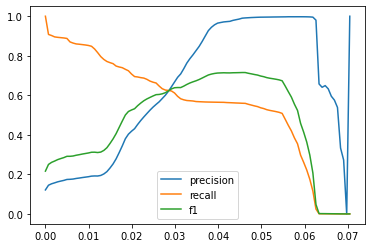

In [82]:
plt.plot(thresholds, precisions, label = "precision")
plt.plot(thresholds, recalls, label = "recall")
plt.plot(thresholds, f1s, label = "f1")
plt.legend()
plt.show()

In [83]:
threshold_idx = np.argmax(f1s)

In [84]:
best_threshold = thresholds[threshold_idx]

In [85]:
best_threshold

0.04553977865387151

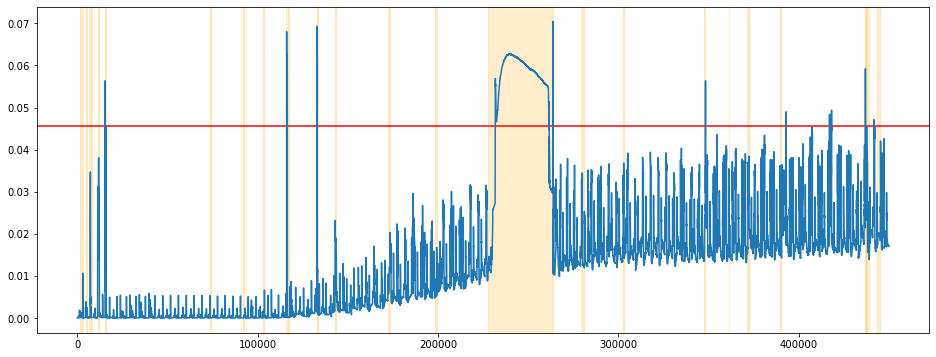

In [86]:
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot()
ax.axhline(y = best_threshold, color = "r")
ax.plot(x, y)
plt.rcParams['axes.facecolor']='white'
for s, e in intervals:
    ax.axvspan(s, e, alpha=0.2, color='orange')

In [87]:
anomaly_prediction = (anomaly_scores > best_threshold).astype(int)
target_y = test_y[args.window_size-1:]

p, r, f = precision_score(target_y, anomaly_prediction), recall_score(target_y, anomaly_prediction),f1_score(target_y, anomaly_prediction)
p, r, f

(0.9901817828327014, 0.5598343837021837, 0.7152671309029198)

In [88]:
print(confusion_matrix(target_y, anomaly_prediction))

[[394933    303]
 [ 24026  30558]]


<AxesSubplot:>

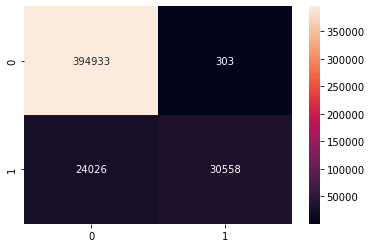

In [89]:
sns.heatmap(confusion_matrix(target_y, anomaly_prediction), annot = True, fmt = "d")